In [2]:
import os
import torch
import utils
import timstof_PASEF_20250506
# from copy import deepcopy
# import model_handler
# from score_model import DIArtModel
import torch.nn as nn
# from score_model import FeatureEngineer
import pandas as pd
import numpy as np

def get_rt_list(lst, target):
    lst.sort()
    if not lst:
        return [0] * 48
    if len(lst) <= 48:
        return lst + [0] * (48 - len(lst))
    closest_idx = min(range(len(lst)), key=lambda i: abs(lst[i] - target))
    start = max(0, closest_idx - 24)
    end = start + 48
    if end > len(lst):
        start = len(lst) - 48
        end = len(lst)
    return lst[start:end]
  
bruker_d_folder_name = '/Users/augustsirius/Desktop/DIABERT_test_code_lib/CAD20220207yuel_TPHP_DIA_pool1_Slot2-54_1_4382.d'
timstof_data = timstof_PASEF_20250506.TimsTOF(bruker_d_folder_name)
# df = deepcopy(timstof_data[:,:,:,:,:])

/Users/augustsirius/Desktop/DIABERT_test_code_lib/20250716/重要python/timstof_PASEF_20250506.py:237: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  frames.Id[0] = 0
/Users/augustsirius/Desktop/DIABERT_test_code_lib/20250716/重要python/timstof_PAS

In [4]:
# **************** 下面两个按照实际传入************************
library = pd.read_csv(r"/Users/augustsirius/Desktop/DIABERT_test_code_lib/helper/lib/TPHPlib_frag1025_swissprot_final_all_from_Yueliang.tsv", sep="\t")
report_diann = pd.read_parquet('/Users/augustsirius/Desktop/DIABERT_test_code_lib/helper/report/report.parquet')
report_diann['transition_group_id'] = report_diann['Precursor.Id']

# col mapping
lib_col_dict = utils.get_lib_col_dict()
for col in set(library.columns) & set(lib_col_dict.keys()):
    library.loc[:, lib_col_dict[col]] = library.loc[:, col]

replacement_dict = {'b': 1, 'y': 2, 'p': 3}
# 生成decoy lib
library['transition_group_id'] = library['FullUniModPeptideName'] + library['PrecursorCharge'].astype(str)
library['FragmentType'] = library['FragmentType'].replace(replacement_dict)
library['decoy'] = 0

# 注意这里从diann中获取，每个precursor的rt数据，按照字典形式传入
diann_result = pd.merge(library[['transition_group_id', 'PrecursorMz', 'ProductMz']], report_diann[['transition_group_id', 'RT', 'IM','iIM']], on='transition_group_id', how='left').dropna(subset=['RT'])
diann_precursor_id_all = diann_result.drop_duplicates(subset=['transition_group_id'])[['transition_group_id', 'RT', 'IM']].reset_index(drop=True)
assay_rt_kept_dict = dict(zip(diann_precursor_id_all['transition_group_id'], diann_precursor_id_all['RT']))
assay_im_kept_dict = dict(zip(diann_precursor_id_all['transition_group_id'], diann_precursor_id_all['IM']))

# precursor_id_all = library['transition_group_id'].unique()
precursor_id_all = list(assay_rt_kept_dict.keys())
precursor_id_list_arr = utils.list_split(precursor_id_all, 500)

device = 'cpu'
frag_repeat_num = 5


/var/folders/r_/1rx2ntgs4296v4jr0jc9bptw0000gn/T/ipykernel_70504/1167788424.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  library['FragmentType'] = library['FragmentType'].replace(replacement_dict)


In [11]:
# 可以先提取这一个precursor的peak group
precursor_id_all.index('(UniMod:1)AAAMDVDTPSGTNSGAGK2')
precursor_id_list_arr[26][490]


target = '(UniMod:1)AAAMDVDTPSGTNSGAGK2'
idx = precursor_id_all.index(target)
batch_idx = idx // 500
pos = idx % 500

print(f"{target}: batch {batch_idx}, position {pos}")
print(f"值: {precursor_id_list_arr[batch_idx][pos]}")

(UniMod:1)AAAMDVDTPSGTNSGAGK2: batch 126, position 446
值: (UniMod:1)AAAMDVDTPSGTNSGAGK2


处理 batch 126, position 446
Batch 126 包含 500 个precursors
目标precursor: (UniMod:1)AAAMDVDTPSGTNSGAGK2
IM: 1.1057177782058716, RT: 48.632442474365234


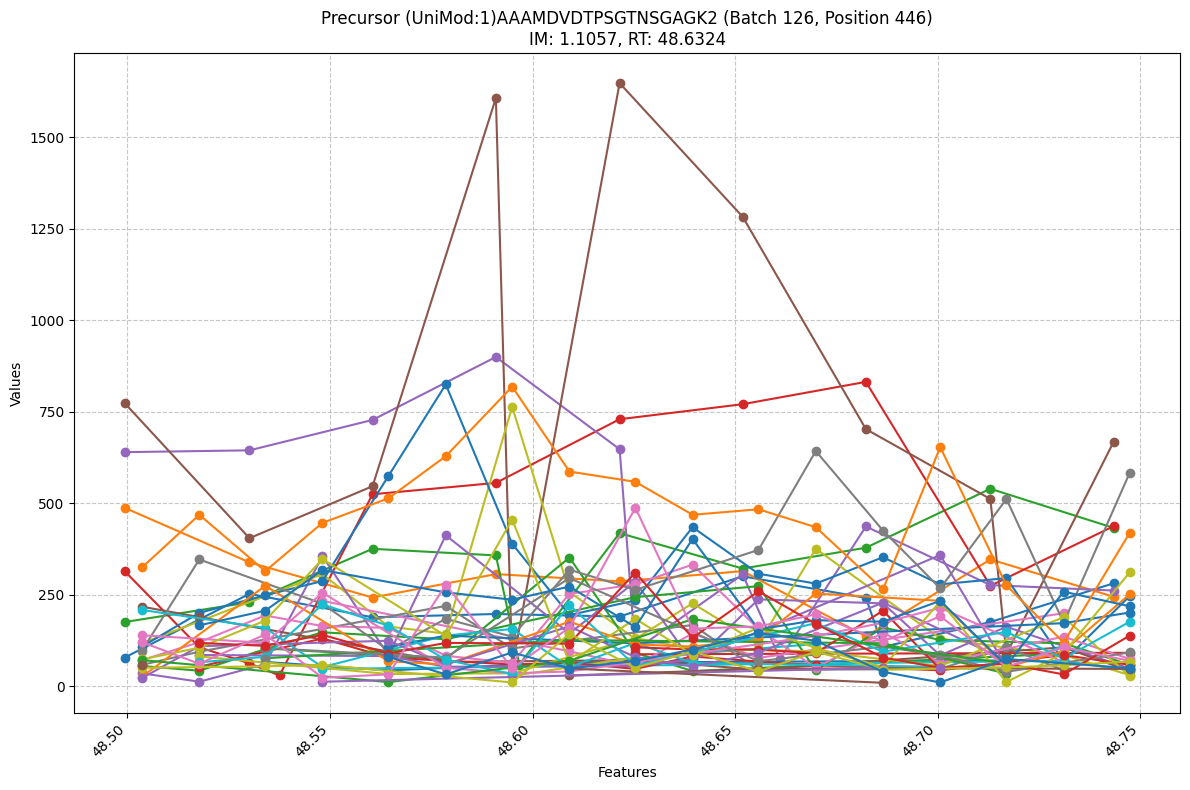

In [12]:
def plot_precursor(batch_idx, position_in_batch):
    """
    输入batch索引和在batch中的位置，自动运行完整流程并生成plot
    
    Args:
        batch_idx: batch索引 (例如 138)
        position_in_batch: 在该batch中的位置 (例如 75)
    """
    
    print(f"处理 batch {batch_idx}, position {position_in_batch}")
    
    # 1. 获取对应batch的precursor列表
    precursor_id_list = precursor_id_list_arr[batch_idx]
    print(f"Batch {batch_idx} 包含 {len(precursor_id_list)} 个precursors")
    
    # 2. 构建库数据
    each_lib_data = library[library['transition_group_id'].isin(precursor_id_list)]
    precursors_list, ms1_data_list, ms2_data_list, precursor_info_list = utils.build_lib_matrix(
                each_lib_data,
                utils.lib_cols,
                None,
                None,
                5,
                1801,
                20,
                None)
    
    # 3. 构建张量和矩阵
    ms1_data_tensor, ms2_data_tensor = utils.build_precursors_matrix_step1(ms1_data_list, ms2_data_list, device)
    ms2_data_tensor = utils.build_precursors_matrix_step2(ms2_data_tensor)
    ms1_range_list, ms2_range_list = utils.build_range_matrix_step3(ms1_data_tensor, ms2_data_tensor, frag_repeat_num, device=device)
    ms1_data_tensor, ms2_data_tensor, ms1_extract_width_range_list, ms2_extract_width_range_list = utils.build_precursors_matrix_step3(ms1_data_tensor, ms2_data_tensor, frag_repeat_num, device=device)
    
    # 4. 构建precursor特征
    precursor_info_np_org = np.array(precursor_info_list)
    precursor_info_choose = precursor_info_np_org[:, 0: 5]
    delta_rt_kept = np.array([0] * len(precursor_info_choose)).reshape(-1, 1)
    assay_rt_kept = np.array([assay_rt_kept_dict[ee[0]] for ee in precursors_list]).reshape(-1, 1)
    assay_im_kept = np.array([assay_im_kept_dict[ee[0]] for ee in precursors_list]).reshape(-1, 1)
    precursor_feat = np.column_stack([precursor_info_choose, assay_im_kept, assay_rt_kept, delta_rt_kept])
    
    # 5. 构建fragment信息
    frag_info = utils.build_frag_info(ms1_data_tensor, ms2_data_tensor, frag_repeat_num, device)
    
    # 6. 使用指定位置的precursor
    i = position_in_batch
    if i >= len(precursor_feat):
        print(f"错误：位置 {i} 超出范围，该batch只有 {len(precursor_feat)} 个precursors")
        return
    
    IM = precursor_feat[i][5]
    RT = precursor_feat[i][6]
    precursor_id = precursors_list[i][0]
    print(f"目标precursor: {precursor_id}")
    print(f"IM: {IM}, RT: {RT}")
    
    # 7. 提取MS1数据
    ms1_range = slice((ms1_range_list[i].min().item()-1)/1000, (ms1_range_list[i].max().item()+1)/1000)
    precursor_result = timstof_data[:, :, 0, ms1_range][['rt_values_min', 'mobility_values', 'mz_values', 'intensity_values']]
    precursor_result['mz_values'] = np.ceil(precursor_result['mz_values'] * 1000)
    precursor_result = precursor_result[(precursor_result['mobility_values'] <= IM + 0.05) & (precursor_result['mobility_values'] >= IM - 0.05)]
    
    # 8. 提取MS2数据
    frag_result = []
    for j in range(0, 66):
        ms2_range = slice((ms2_range_list[i][j].min().item()-1)/1000, (ms2_range_list[i][j].max().item()+1)/1000)
        frag_result.append(timstof_data[:, :, ms1_range, ms2_range][['rt_values_min', 'mobility_values',  'mz_values', 'intensity_values']])
    frag_result = pd.concat(frag_result, ignore_index=True)
    frag_result['mz_values'] = np.ceil(frag_result['mz_values'] * 1000)
    frag_result = frag_result[(frag_result['mobility_values'] <= IM + 0.05) & (frag_result['mobility_values'] >= IM - 0.05)]
    
    # 9. 构建掩码矩阵
    search_ms1_tensor = torch.tensor(list(precursor_result['mz_values']))
    search_ms2_tensor = torch.tensor(list(frag_result['mz_values']))
    mask_ms1 = torch.isin(ms1_extract_width_range_list[i], search_ms1_tensor)
    mask_ms2 = torch.isin(ms2_extract_width_range_list[i], search_ms2_tensor)
    ms1_frag_moz_matrix = torch.where(mask_ms1, 1., 0.)
    ms2_frag_moz_matrix = torch.where(mask_ms2, 1., 0.)
    
    # 10. 获取RT列表
    all_rt = get_rt_list(list(set(list(precursor_result['rt_values_min'].unique())+list(frag_result['rt_values_min'].unique()))), RT)
    
    # 11. 构建MS1强度矩阵
    ms1_frag_rt_matrix = []
    for a in range(len(ms1_extract_width_range_list[i])):
        ms1_moz_rt_matrix = []
        for rt in all_rt:
            grouped = precursor_result[precursor_result['rt_values_min'] == rt].groupby('mz_values')['intensity_values'].sum()
            moz_to_intensity = grouped.to_dict()
            mapped_intensities = torch.tensor([moz_to_intensity.get(moz.item(), 0) for moz in ms1_extract_width_range_list[i][a]], 
                                            dtype=torch.float32)
            ms1_moz_rt_matrix.append(mapped_intensities)
        ms1_moz_rt_matrix = torch.stack(ms1_moz_rt_matrix, dim=1)
        ms1_frag_rt = ms1_frag_moz_matrix[a] @ ms1_moz_rt_matrix
        ms1_frag_rt_matrix.append(ms1_frag_rt)
    ms1_frag_rt_matrix = torch.stack(ms1_frag_rt_matrix, dim=0)
    
    # 12. 构建MS2强度矩阵
    ms2_frag_rt_matrix = []
    for b in range(len(ms2_extract_width_range_list[i])):
        ms2_moz_rt_matrix = []
        for rt in all_rt:
            grouped = frag_result[frag_result['rt_values_min'] == rt].groupby('mz_values')['intensity_values'].sum()
            moz_to_intensity = grouped.to_dict()
            mapped_intensities = torch.tensor([moz_to_intensity.get(moz.item(), 0) for moz in ms2_extract_width_range_list[i][b]], 
                                            dtype=torch.float32)
            ms2_moz_rt_matrix.append(mapped_intensities)
        ms2_moz_rt_matrix = torch.stack(ms2_moz_rt_matrix, dim=1)
        ms2_frag_rt = ms2_frag_moz_matrix[b] @ ms2_moz_rt_matrix
        ms2_frag_rt_matrix.append(ms2_frag_rt)
    ms2_frag_rt_matrix = torch.stack(ms2_frag_rt_matrix, dim=0)
    
    # 13. 重塑和合并矩阵
    ms1_frag_rt_matrix_shape = ms1_frag_rt_matrix.shape
    ms1_frag_rt_matrix1 = ms1_frag_rt_matrix.reshape(frag_repeat_num, ms1_frag_rt_matrix_shape[0] // frag_repeat_num, ms1_frag_rt_matrix_shape[1])
    ms2_frag_rt_matrix_shape = ms2_frag_rt_matrix.shape
    ms2_frag_rt_matrix1 = ms2_frag_rt_matrix.reshape(frag_repeat_num, ms2_frag_rt_matrix_shape[0] // frag_repeat_num, ms2_frag_rt_matrix_shape[1])
    
    full_frag_rt_matrix = torch.cat([ms1_frag_rt_matrix1, ms2_frag_rt_matrix1], dim=1)
    rsm_matrix = [full_frag_rt_matrix]
    rsm_matrix = torch.stack(rsm_matrix, dim=0)
    aggregated_x_sum = torch.sum(rsm_matrix, dim=1)
    
    # 14. 创建DataFrame
    header = all_rt + ['ProductMz', 'LibraryIntensity', 'frag_type', 'FragmentType']
    merged_tensor = torch.cat((aggregated_x_sum[0], frag_info[i]), dim=1)
    numpy_array = merged_tensor.cpu().numpy()
    data = pd.DataFrame(numpy_array)
    data.columns = header
    
    # 15. 绘图
    import matplotlib.pyplot as plt
    
    filtered_df = data[data['frag_type'].isin([1, 2])]
    columns_to_plot = filtered_df.drop(columns=['frag_type','ProductMz','LibraryIntensity','FragmentType']).columns
    values_to_plot = filtered_df[columns_to_plot].values
    row_indices = filtered_df.index
    
    plt.figure(figsize=(12, 8))
    
    for t, row_values in enumerate(values_to_plot):
        original_row_index = row_indices[t]
        category_value = filtered_df.loc[original_row_index, 'frag_type']
        row_series = pd.Series(row_values, index=columns_to_plot)
        non_zero_series = row_series[row_series != 0]
        plt.plot(non_zero_series.index, non_zero_series.values, marker='o',
                 label=f'Row {original_row_index} (frag_type: {category_value})')
    
    plt.xlabel('Features')
    plt.ylabel('Values')
    plt.title(f'Precursor {precursor_id} (Batch {batch_idx}, Position {position_in_batch})\nIM: {IM:.4f}, RT: {RT:.4f}')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return data

# 使用示例：
# 输入你想要的batch和position
batch_idx = 126
position_in_batch = 446

# 运行完整流程
result_data = plot_precursor(batch_idx, position_in_batch)

In [ ]:
# ============================================================== 以下是原代码 =====================================================

In [ ]:
precursor_id_list = precursor_id_list_arr[26]
each_lib_data = library[library['transition_group_id'].isin(precursor_id_list)]
precursors_list, ms1_data_list, ms2_data_list, precursor_info_list = utils.build_lib_matrix(
            each_lib_data,
            utils.lib_cols,
            None,
            None,
            5,
            1801,
            20,
            None)
ms1_data_tensor, ms2_data_tensor = utils.build_precursors_matrix_step1(ms1_data_list, ms2_data_list, device)
ms2_data_tensor = utils.build_precursors_matrix_step2(ms2_data_tensor)
ms1_range_list, ms2_range_list = utils.build_range_matrix_step3(ms1_data_tensor, ms2_data_tensor, frag_repeat_num, device=device)
ms1_data_tensor, ms2_data_tensor, ms1_extract_width_range_list, ms2_extract_width_range_list = utils.build_precursors_matrix_step3(ms1_data_tensor, ms2_data_tensor, frag_repeat_num, device=device)

In [ ]:
precursor_info_np_org = np.array(precursor_info_list)
precursor_info_choose = precursor_info_np_org[:, 0: 5]
delta_rt_kept = np.array([0] * len(precursor_info_choose)).reshape(-1, 1)

assay_rt_kept = np.array([assay_rt_kept_dict[ee[0]] for ee in precursors_list]).reshape(-1, 1)
assay_im_kept = np.array([assay_im_kept_dict[ee[0]] for ee in precursors_list]).reshape(-1, 1)

# precursor_feat
precursor_feat = np.column_stack([precursor_info_choose, assay_im_kept, assay_rt_kept, delta_rt_kept])
# frag info
frag_info = utils.build_frag_info(ms1_data_tensor, ms2_data_tensor, frag_repeat_num,
                                device)

In [ ]:
i= 490
IM = precursor_feat[i][5]
RT = precursor_feat[i][6]
print(IM, RT)

0.8748147487640381 49.73412322998047 49.55081558227539 49.97819900512695


In [ ]:
ms1_range = slice((ms1_range_list[i].min().item()-1)/1000, (ms1_range_list[i].max().item()+1)/1000)
precursor_result = timstof_data[:, :, 0, ms1_range][['rt_values_min', 'mobility_values', 'mz_values', 'intensity_values']]
precursor_result['mz_values'] = np.ceil(precursor_result['mz_values'] * 1000)
# 根据IM值筛选precursor_result
precursor_result = precursor_result[(precursor_result['mobility_values'] <= IM + 0.05) & (precursor_result['mobility_values'] >= IM - 0.05)]
frag_result = []
for j in range(0, 66):
    ms2_range = slice((ms2_range_list[i][j].min().item()-1)/1000, (ms2_range_list[i][j].max().item()+1)/1000)
    frag_result.append(timstof_data[:, :, ms1_range, ms2_range][['rt_values_min', 'mobility_values',  'mz_values', 'intensity_values']])
frag_result = pd.concat(frag_result, ignore_index=True)
frag_result['mz_values'] = np.ceil(frag_result['mz_values'] * 1000)
# 根据IM值筛选frag_result
frag_result = frag_result[(frag_result['mobility_values'] <= IM + 0.05) & (frag_result['mobility_values'] >= IM - 0.05)]

#### 获取ms1和ms2的frag_moz的0/1矩阵
search_ms1_tensor = torch.tensor(list(precursor_result['mz_values']))
search_ms2_tensor = torch.tensor(list(frag_result['mz_values']))
mask_ms1 = torch.isin(ms1_extract_width_range_list[i], search_ms1_tensor)
mask_ms2 = torch.isin(ms2_extract_width_range_list[i], search_ms2_tensor)
ms1_frag_moz_matrix = torch.where(mask_ms1, 1., 0.)
ms2_frag_moz_matrix = torch.where(mask_ms2, 1., 0.)

In [ ]:
all_rt = get_rt_list(list(set(list(precursor_result['rt_values_min'].unique())+list(frag_result['rt_values_min'].unique()))), RT)

rsm_matrix = []
#### 获取ms1的frag_rt的intensity矩阵
ms1_frag_rt_matrix = []
for a in range(len(ms1_extract_width_range_list[i])):
    #### 获取ms1的moz_rt的intensity矩阵
    ms1_moz_rt_matrix = []
    for rt in all_rt:
        grouped = precursor_result[precursor_result['rt_values_min'] == rt].groupby('mz_values')['intensity_values'].sum()
        moz_to_intensity = grouped.to_dict()
        # moz_to_intensity = dict(zip(precursor_result[precursor_result['rt_values_min'] == rt]['mz_values'], 
                                    # precursor_result[precursor_result['rt_values_min'] == rt]['intensity_values']))
        mapped_intensities = torch.tensor([moz_to_intensity.get(moz.item(), 0) for moz in ms1_extract_width_range_list[i][a]], 
                                        dtype=torch.float32)
        ms1_moz_rt_matrix.append(mapped_intensities)
    ms1_moz_rt_matrix = torch.stack(ms1_moz_rt_matrix, dim=1)
    ### 矩阵相乘
    ms1_frag_rt = ms1_frag_moz_matrix[a] @ ms1_moz_rt_matrix
    ms1_frag_rt_matrix.append(ms1_frag_rt)
ms1_frag_rt_matrix = torch.stack(ms1_frag_rt_matrix, dim=0)

#### 获取ms2的frag_rt的intensity矩阵
ms2_frag_rt_matrix = []
for b in range(len(ms2_extract_width_range_list[i])):
    #### 获取ms2的moz_rt的intensity矩阵
    ms2_moz_rt_matrix = []
    for rt in all_rt:
        grouped = frag_result[frag_result['rt_values_min'] == rt].groupby('mz_values')['intensity_values'].sum()
        moz_to_intensity = grouped.to_dict()
        # moz_to_intensity = dict(zip(frag_result[frag_result['rt_values_min'] == rt]['mz_values'], 
                                    # frag_result[frag_result['rt_values_min'] == rt]['intensity_values']))
        mapped_intensities = torch.tensor([moz_to_intensity.get(moz.item(), 0) for moz in ms2_extract_width_range_list[i][b]], 
                                        dtype=torch.float32)
        ms2_moz_rt_matrix.append(mapped_intensities)
    ms2_moz_rt_matrix = torch.stack(ms2_moz_rt_matrix, dim=1)
    ### 矩阵相乘
    ms2_frag_rt = ms2_frag_moz_matrix[b] @ ms2_moz_rt_matrix
    ms2_frag_rt_matrix.append(ms2_frag_rt)
ms2_frag_rt_matrix = torch.stack(ms2_frag_rt_matrix, dim=0)
ms1_frag_rt_matrix_shape = ms1_frag_rt_matrix.shape
ms1_frag_rt_matrix1 = ms1_frag_rt_matrix.reshape(frag_repeat_num, ms1_frag_rt_matrix_shape[0] // frag_repeat_num, ms1_frag_rt_matrix_shape[1])
ms2_frag_rt_matrix_shape = ms2_frag_rt_matrix.shape
ms2_frag_rt_matrix1 = ms2_frag_rt_matrix.reshape(frag_repeat_num, ms2_frag_rt_matrix_shape[0] // frag_repeat_num, ms2_frag_rt_matrix_shape[1])

full_frag_rt_matrix = torch.cat([ms1_frag_rt_matrix1, ms2_frag_rt_matrix1], dim=1)
rsm_matrix.append(full_frag_rt_matrix)
rsm_matrix = torch.stack(rsm_matrix, dim=0)
aggregated_x_sum = torch.sum(rsm_matrix, dim=1)

header = all_rt+['ProductMz', 'LibraryIntensity', 'frag_type', 'FragmentType']
merged_tensor = torch.cat((aggregated_x_sum[0], frag_info[i]), dim=1)
numpy_array = merged_tensor.cpu().numpy()
data = pd.DataFrame(numpy_array)
data.columns = header

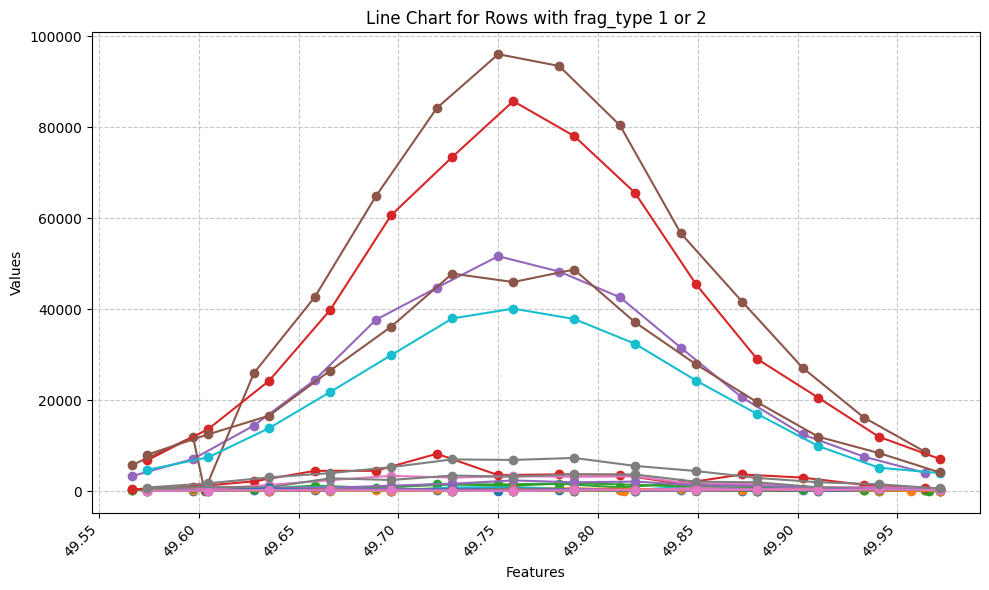

In [ ]:
import matplotlib.pyplot as plt
# plot im+-0.05
filtered_df = data[data['frag_type'].isin([1, 2])]
columns_to_plot = filtered_df.drop(columns=['frag_type','ProductMz','LibraryIntensity','FragmentType']).columns
values_to_plot = filtered_df[columns_to_plot].values
row_indices = filtered_df.index
plt.figure(figsize=(10, 6)) # Creates/selects the single figure
# for t, row_values in enumerate(values_to_plot):
#     original_row_index = row_indices[t]
#     category_value = filtered_df.loc[original_row_index, 'frag_type']
#     # Each call to plt.plot adds a new line to the *same* figure
#     plt.plot(columns_to_plot, row_values, marker='o',
#             label=f'Original Row {original_row_index} (frag_type: {category_value})')
for t, row_values in enumerate(values_to_plot):
    original_row_index = row_indices[t]
    category_value = filtered_df.loc[original_row_index, 'frag_type']
    # 转换为 Series 方便处理索引
    row_series = pd.Series(row_values, index=columns_to_plot)
    # 仅保留非零值
    non_zero_series = row_series[row_series != 0]
    # 绘图：只连接非零的值
    plt.plot(non_zero_series.index, non_zero_series.values, marker='o',
             label=f'Row {original_row_index} (frag_type: {category_value})')
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Line Chart for Rows with frag_type 1 or 2')
plt.xticks(rotation=45, ha='right')
# plt.legend(title='Row Information')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()